In [13]:
from pathlib import Path
import tw_textlabs
from tw_textlabs.generator.lab_game import LabGameOptions
from tw_textlabs.utils import uniquify
from tw_textlabs.generator import LabGameMaker
from tw_textlabs.generator.data import KnowledgeBase
from tw_textlabs.generator.surface_generator import SurfaceGenerator
from tw_textlabs.challenges.utils import get_seeds_for_game_generation
from tw_textlabs.utils import encode_seeds
from tw_textlabs.generator.lab_game import LabGameOptions
from tw_textlabs.generator.quest_generator import QuestGenerationOptions, WinConditionType, init_usage_map
from tw_textlabs.generator.process_graph import ProcessGraph

# Set generation options

In [14]:
seed = 12345

lab_game_options = LabGameOptions()

lab_game_options.seeds = seed
lab_game_options.preset_ops = True
lab_game_options.max_quest_length = 80

# set number of materials and operations in the quest
n_materials = 4
n_ops = 6
lab_game_options.sketch_gen_options.nb_materials = n_materials
lab_game_options.sketch_gen_options.nb_ops = n_ops

# set maximum number of descriptors possible per entity
max_descs_per_ent = 2
lab_game_options.sketch_gen_options.max_descs_per_ent = init_usage_map(max_descs_per_ent)

# get all currently available operation types
all_op_types = KnowledgeBase.default().types.descendants('toe')

# randonly select op types to be used
rng_objects = lab_game_options.rngs['objects']
chosen_op_types = rng_objects.choice(all_op_types, n_ops, replace=True)

# Set surface generation flags
surface_gen_options = lab_game_options.surface_gen_options
surface_gen_options.implicit_refs = True
surface_gen_options.merge_serial_actions = True
if lab_game_options.preset_ops:
    surface_gen_options.op_type_map = {'tlq_op_{}'.format(i): chosen_op_types[i] for i in range(n_ops)}

sg = SurfaceGenerator(surface_gen_options=surface_gen_options)

# Add entites to world

In [15]:

quest_gen_options = lab_game_options.sketch_gen_options
max_quest_length = quest_gen_options.max_depth
quest_gen_options.win_condition = WinConditionType.ALL

M = LabGameMaker(surface_generator=sg)

# Create the lab room and set player in it.
lab = M.new_room("lab")
M.set_player(lab)

# - Describe the room.
lab.desc = "The lab is a magical place where you'll learn materials synthesis"


# Add materials to the world.
material_states = ['powder', 'liquid', 'solid']
ent_type = 'm'
n_max_descs = quest_gen_options.max_descs_per_ent[ent_type]
for i in range(n_materials):
    mat_state = rng_objects.choice(material_states)
    mat = M.new_lab_entity('m')
    mat.add_property(mat_state)
    lab.add(mat)
    # add material descriptors
    n_descs = rng_objects.randint(0, (n_max_descs + 1))
    for j in range(n_descs):
        mdesc = M.new_lab_entity('mdsc')
        lab.add(mdesc)
        quest_gen_options.ent_desc_map[mat.var.name].append(mdesc.var.name)
        

# Add operations and their descriptors
ent_type = 'tlq_op'
n_max_descs = quest_gen_options.max_descs_per_ent[ent_type]
    
# Either preset ops 
if lab_game_options.preset_ops:
    ops = [M.new_tlq_op(dynamic_define=False, op_type=chosen_op_types[i]) for i in range(n_ops)]
else: # or make their classification part of the quest
    ops = [M.new_tlq_op(dynamic_define=True) for i in range(n_ops)]

for op in ops:
    lab.add(op)
    # randomly select number of descriptors to be set for each operation
    n_descs = rng_objects.randint(0, (n_max_descs + 1))
    for j in range(n_descs):
        odesc = M.new_lab_entity('odsc')
        lab.add(odesc)
        quest_gen_options.ent_desc_map[op.var.name].append(odesc.var.name)

# Generate random quest, surface pair from initial conditions

In [16]:
# Generate quest and corresponding surface (set in quest description)
quest = M.generate_quest_surface_pair(quest_gen_options)
game = M.build()

2019-04-04 15:44:05,224 | INFO : Searching for quest satisfying constraints...
2019-04-04 15:45:00,008 | INFO : Found solution!
2019-04-04 15:45:00,015 | INFO : Found quest: [take(mdsc_0), dlink(mdsc_0,m_1), take(mdsc_1), dlink(mdsc_1,m_2), take(mdsc_2), dlink(mdsc_2,m_2), take(mdsc_3), dlink(mdsc_3,m_3), take(odsc_0), dlink(odsc_0,tlq_op_0), take(odsc_1), dlink(odsc_1,tlq_op_0), take(odsc_2), dlink(odsc_2,tlq_op_2), take(odsc_3), dlink(odsc_3,tlq_op_5), take(m_3), op_ia_assign(m_3,tlq_op_1), op_run(tlq_op_1), take(m_1), op_ia_assign(m_1,tlq_op_5), op_run(tlq_op_5), take(m_2), op_ia_assign(m_2,tlq_op_2), op_run(tlq_op_2), op_o_obtain(tlq_op_1), op_ia_assign(m_3,tlq_op_0), op_run(tlq_op_0), op_o_obtain(tlq_op_2), op_ia_assign(m_2,tlq_op_3), take(m_0), op_ia_assign(m_0,tlq_op_3), op_o_obtain(tlq_op_5), op_ia_assign(m_1,tlq_op_3), op_o_obtain(tlq_op_0), op_ia_assign(m_3,tlq_op_4), op_run(tlq_op_4), op_o_obtain(tlq_op_4), op_ia_assign(m_3,tlq_op_3), op_run(tlq_op_3), op_o_obtain(tlq_op_3)]

The initial materials are mg, mn, na and fe. First, take mg. Following that, take mn. After that, take na. Next, take fe. In the next stage, describe op1 with opdesc3. Next, describe op5 with opdesc2 and opdesc11. After that, finely grind (op8), obtain, press (op5) and obtain fe. Next, describe op4 with opdesc12. Next, describe op2 with opdesc6 and opdesc7. Next, describe na with matdesc10. After that, describe mn with matdesc6 and matdesc2. Following that, dry out (op1), obtain, mill (op7) and obtain mn. Following that, describe mg with matdesc12. After that, quench (op4) mg. After that, obtain mg. Following that, heat (op2) the materials. Finally, obtain the result of op2.


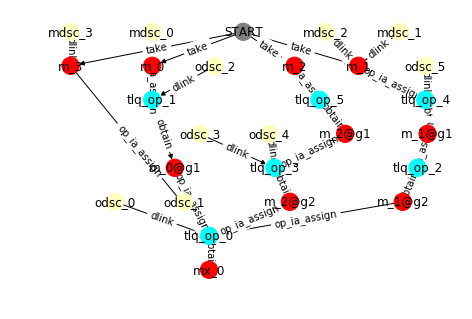

In [9]:
# Draw material synthesis quest (game solution)
pg = ProcessGraph()
pg.from_tw_actions(quest.actions)
pg.draw()
print(quest.desc)

In [17]:
# compile it
lab_game_options.path = str(Path("gen_games") / ("game_{}.ulx".format(seed)))
lab_game_options.force_compile = True
game_file = tw_textlabs.generator.compile_game(game, lab_game_options)
print("*** Game created: {}".format(game_file))

*** Game created: gen_games/game_12345.ulx
